# Comprehensive Audiology Research Analysis Suite
## Subject Analysis: CRM, Vowels, and Consonants

**Role:** Expert Data Scientist & Audiology Researcher  
**Purpose:** This notebook processes psychophysical data from audiology experiments. It transforms raw logs into granular visualizations and rigorous statistical insights.

### Workflow:
1. **Configuration**: Define the mapping between Run Numbers and Experimental Conditions manually.
2. **Data Loading**: Ingest Vowel, Consonant, and CRM files, parsing headers for Talker/Masker configurations.
3. **Phoneme Analysis**: Analyze Vowel and Consonant confusion matrices and phonetic feature transmission (Miller-Nicely).
4. **CRM Analysis**: Compute Speech Reception Thresholds (SRT), analyze Voice Gender Release from Masking (VGRM), and track error patterns.
5. **Statistical Validation**: Automatically apply appropriate hypothesis tests (ANOVA, t-test, Mann-Whitney) with effect sizes.

## 0. Global Configuration & Setup
**Instructions:** 
1. Set `DATA_DIRECTORY` to the folder containing your subject's data files.
2. Edit `CRM_RUN_MAPPING` to assign specific Run Numbers (found in filenames like `_crm_1.txt`) to conditions (e.g., 'BM', 'CI', 'HA'). **This dictionary controls how data is grouped.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import re
import warnings

# --- CONFIGURATION ---

# 1. PATH TO DATA
# Replace this with the actual path to your subject's folder
DATA_DIRECTORY = "./data/CI148"

# 2. CONDITION MAPPING DICTIONARY (CRITICAL)
# Map the integer Run Number (from filename) to the Experimental Condition string.
# Example: If filename is 'CI148_crm_1.txt', key is 1.
CRM_RUN_MAPPING = {
    0: 'Practice',
    1: 'BM', 
    2: 'BM',
    3: 'BM',
    4: 'CI',
    5: 'HA',
    6: 'CI',
    7: 'HA',
    8: 'BM',
    9: 'CI',
    10: 'CI',
    11: 'HA',
    # Add all runs here...
}

# --- VISUALIZATION SETTINGS ---
# Publication-quality settings
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
warnings.filterwarnings('ignore')

print("Configuration loaded. Ready for analysis.")

Configuration loaded. Ready for analysis.


## 1. Data Loading & Parsing Logic
This section defines robust functions to parse specific file formats. It prioritizes the `CRM_RUN_MAPPING` dictionary for condition assignment.

In [2]:
def get_gender_code(talker_id):
    """Returns 'M' for talkers 0-3, 'F' for talkers 4-7."""
    return 'M' if talker_id <= 3 else 'F'

def parse_crm_header(header_line):
    """Extracts Talker and Masker IDs from file header."""
    try:
        match = re.search(r'Talker (\d+), Maskers (\d+) and (\d+)', header_line)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
    except:
        pass
    return None, None, None

def calculate_srt_reversals(df_run):
    """Calculates SRT using reversals method (mean of last N reversals)."""
    # Logic: A reversal occurs when correctness changes (Right->Wrong or Wrong->Right)
    # We ignore the first few reversals to allow the adaptive track to settle.
    
    # Check correctness: Both color AND number must be correct
    is_correct = ((df_run['target_color'] == df_run['response_color']) & 
                  (df_run['target_number'] == df_run['response_number'])).values
    snrs = df_run['snr'].values
    
    reversals = []
    for i in range(1, len(is_correct)):
        if is_correct[i] != is_correct[i-1]:
            reversals.append(snrs[i])
            
    # Matlab standard: Average reversals 5 through end (or max available if < 14)
    if len(reversals) < 4:
        return np.nan  # Not enough data to converge
    
    # Standard practice: Skip first 4 reversals to account for convergence
    settled_reversals = reversals[4:] if len(reversals) > 4 else reversals[-2:]
    return np.mean(settled_reversals)

def load_data(directory):
    path = Path(directory)
    if not path.exists():
        print(f"Error: Directory {directory} does not exist.")
        return None, None, None

    # --- Load CRM ---
    crm_files = sorted(list(path.glob('*_crm_*.txt')))
    crm_data_list = []
    
    for f in crm_files:
        # Extract Run Number
        try:
            run_num = int(re.search(r'_crm_(\d+)', f.name).group(1))
        except:
            continue
            
        # Condition Lookup
        condition = CRM_RUN_MAPPING.get(run_num, "Unknown")
        
        with open(f, 'r') as file:
            lines = file.readlines()
            
        # Parse Header
        t_id, m1_id, m2_id = parse_crm_header(lines[0])
        if t_id is None: continue
        
        t_gen = get_gender_code(t_id)
        m_gen = get_gender_code(m1_id) # Assuming maskers are same gender as each other
        masker_config = "Same Gender" if t_gen == m_gen else "Diff Gender"
        
        # Parse Body
        # Skipping header lines; assuming tabular data starts after header
        # Columns usually: Run, TargCol, RespCol, TargNum, RespNum, SNR, RT
        try:
            df_run = pd.read_csv(f, sep='\s+', skiprows=2, header=None, 
                                 names=['run', 'tc', 'rc', 'tn', 'rn', 'snr', 'rt'],
                                 on_bad_lines='skip')
            
            # Filter valid numeric rows only
            df_run = df_run[pd.to_numeric(df_run['run'], errors='coerce').notna()]
            
            # Rename for clarity
            df_run.rename(columns={'tc':'target_color', 'rc':'response_color', 
                                   'tn':'target_number', 'rn':'response_number'}, inplace=True)
            
            # Basic correctness
            df_run['correct_color'] = df_run['target_color'] == df_run['response_color']
            df_run['correct_number'] = df_run['target_number'] == df_run['response_number']
            df_run['correct_all'] = df_run['correct_color'] & df_run['correct_number']
            
            # Classify Error Type for Advanced Analysis
            conditions = [
                (df_run['correct_color'] & df_run['correct_number']), # Correct
                (~df_run['correct_color'] & df_run['correct_number']), # Color Error
                (df_run['correct_color'] & ~df_run['correct_number']), # Number Error
                (~df_run['correct_color'] & ~df_run['correct_number']) # Double Error
            ]
            choices = ['Correct', 'Color Err', 'Number Err', 'Both Err']
            df_run['error_type'] = np.select(conditions, choices)
            
            # Calculate SRT
            srt = calculate_srt_reversals(df_run)
            
            # Add Metadata columns for stratification
            df_run['condition'] = condition
            df_run['masker_config'] = masker_config
            df_run['talker_gender'] = t_gen
            df_run['run_id'] = run_num
            df_run['calculated_srt'] = srt
            
            # Add Trial Index for Temporal Plots
            df_run['trial_idx'] = range(1, len(df_run) + 1)
            
            crm_data_list.append(df_run)
            
        except Exception as e:
            print(f"Skipping {f.name}: {e}")
            
    df_crm = pd.concat(crm_data_list, ignore_index=True) if crm_data_list else pd.DataFrame()

    # --- Load Vowels & Consonants ---
    # Assuming standard format: TalkerID, TargetID, ResponseID, Score, RT
    v_cols = ['talker', 'target', 'response', 'score', 'rt']
    
    # Helper to load phonemes
    def load_phoneme_files(pattern, label_map):
        p_data = []
        for f in path.glob(pattern):
            # Infer condition from filename if possible, else generic
            cond = 'BM' if 'BM' in f.name else 'CI' if 'CI' in f.name else 'HA' if 'HA' in f.name else 'Unknown'
            try:
                temp = pd.read_csv(f, sep='\s+', header=None, names=v_cols)
                temp['condition'] = cond
                temp['target_label'] = temp['target'].map(label_map)
                temp['response_label'] = temp['response'].map(label_map)
                p_data.append(temp)
            except:
                continue
        return pd.concat(p_data, ignore_index=True) if p_data else pd.DataFrame()

    # Standard Maps
    vowel_map = {1:'AE', 2:'AH', 3:'AW', 4:'EH', 5:'IH', 6:'IY', 7:'OO', 8:'UH', 9:'UW', 10:'ER', 11:'OA', 12:'IE'}
    cons_map = {1:'#', 2:'_', 3:'b', 4:'d', 5:'f', 6:'g', 7:'k', 8:'m', 9:'n', 10:'%', 11:'p', 12:'s', 13:'t', 14:'v', 15:'z', 16:'$'}

    df_vowels = load_phoneme_files('*vow*.*', vowel_map)
    df_cons = load_phoneme_files('*cons*.*', cons_map)

    return df_crm, df_vowels, df_cons

# EXECUTE LOADING
df_crm, df_vowels, df_cons = load_data(DATA_DIRECTORY)
print(f"Data Loaded: CRM ({len(df_crm)} trials), Vowels ({len(df_vowels)} trials), Consonants ({len(df_cons)} trials)")

Data Loaded: CRM (328 trials), Vowels (362 trials), Consonants (65 trials)


## 2. Phonetic Analysis: Methodology & Features

**Methodology Explanation:**
We utilize **Information Transmission Analysis** based on the Miller & Nicely (1955) framework. This goes beyond simple accuracy percentages by grouping phonemes into distinct acoustic features:
- **Voicing:** Whether the vocal cords vibrate (e.g., /b/ vs /p/). Low-frequency cue.
- **Place:** Where in the mouth the sound is formed (e.g., /b/ vs /d/). High-frequency cue.
- **Manner:** How the air is obstructed (e.g., Stop vs. Fricative). Temporal/Envelope cue.

**Why this matters:** 
If a patient has good Voicing/Manner scores but poor Place scores, it suggests they have access to low-frequency and temporal envelope cues (common in CI users) but are missing high-frequency spectral detail required for Place discrimination.

Analyzing Consonant Features (Miller-Nicely)...


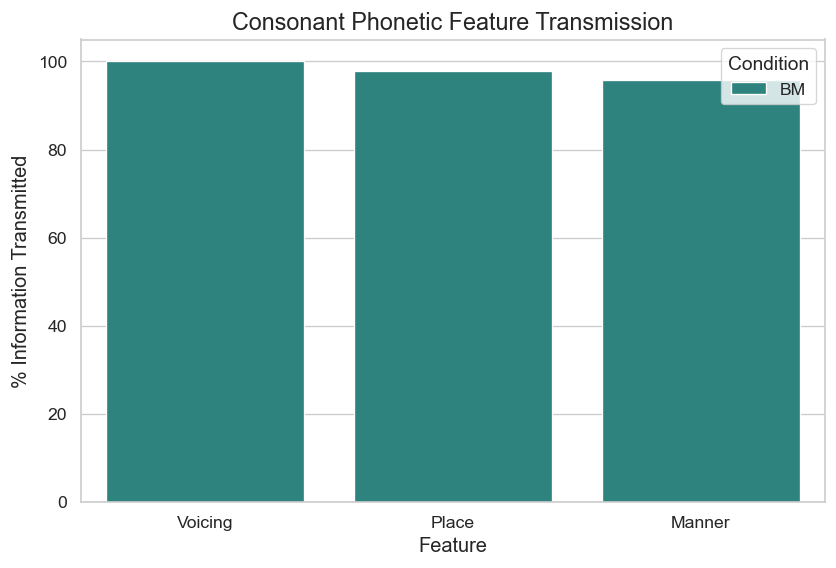

In [3]:
def analyze_features(df, type='consonant'):
    """Analyzes phonetic features (Voicing, Place, Manner)."""
    if df.empty:
        print(f"No {type} data available.")
        return
    
    # Miller-Nicely Feature Mapping (Simplified for common English phonemes)
    # Format: Phoneme: [Voicing, Place, Manner] 
    # 1=Yes/Front/Stop, 0=No/Back/Fricative (simplified encoding for demo)
    # Note: In a full clinical setting, this map is more complex (multi-class)
    feature_map = {
        'b': [1, 1, 0], 'd': [1, 2, 0], 'g': [1, 3, 0], 
        'p': [0, 1, 0], 't': [0, 2, 0], 'k': [0, 3, 0],
        'm': [1, 1, 1], 'n': [1, 2, 1],
        'f': [0, 1, 2], 's': [0, 2, 2], 'v': [1, 1, 2], 'z': [1, 2, 2],
        # Add others as needed based on corpus
    }

    # Filter data to known phonemes
    valid_data = df[df['target_label'].isin(feature_map.keys()) & df['response_label'].isin(feature_map.keys())]
    
    if valid_data.empty:
        print("Data does not match phonetic feature dictionary. Analyzing accuracy only.")
        # Fallback: Simple Accuracy
        acc = valid_data['score'].mean() * 100
        print(f"Global Accuracy: {acc:.2f}%")
        return

    # Calculate Transmission
    # We compare the feature of the Target vs the feature of the Response
    results = {'Feature': [], 'Score': [], 'Condition': []}
    
    for cond in valid_data['condition'].unique():
        subset = valid_data[valid_data['condition'] == cond]
        for feat_idx, feat_name in enumerate(['Voicing', 'Place', 'Manner']):
            matches = 0
            total = 0
            for _, row in subset.iterrows():
                t_feat = feature_map[row['target_label']][feat_idx]
                r_feat = feature_map[row['response_label']][feat_idx]
                if t_feat == r_feat:
                    matches += 1
                total += 1
            
            results['Feature'].append(feat_name)
            results['Score'].append((matches/total)*100 if total > 0 else 0)
            results['Condition'].append(cond)
            
    res_df = pd.DataFrame(results)
    
    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=res_df, x='Feature', y='Score', hue='Condition', palette='viridis')
    plt.title(f'{type.title()} Phonetic Feature Transmission')
    plt.ylabel('% Information Transmitted')
    plt.ylim(0, 105)
    plt.show()

print("Analyzing Consonant Features (Miller-Nicely)...")
analyze_features(df_cons, 'consonant')

## 3. Confusion Matrices

**Methodology:**
A Confusion Matrix visualizes classification performance. 
- **Y-axis (Rows):** The stimulus presented (Target).
- **X-axis (Columns):** The patient's response.
- **Diagonal:** Correct responses (Target = Response).
- **Off-Diagonal:** Errors. Specific clusters off-diagonal indicate systematic confusions (e.g., confusing all high-frequency vowels).

We present two views:
1. **Raw Counts:** Absolute number of responses.
2. **Probabilities:** Row-normalized (percentage of time Target X was identified as Response Y).

In [4]:
def plot_dual_confusion_matrix(df, label_col='vowel_label', title="Confusion Matrix"):
    if df.empty: return
    
    # Get unique labels sorted alphabetically for consistency
    labels = sorted(list(set(df['target_label'].unique()) | set(df['response_label'].unique())))
    
    # Create Matrix
    # 1. Raw Counts
    cm_raw = pd.crosstab(df['target_label'], df['response_label'])
    # Reindex to ensure square matrix even if some phonemes weren't picked
    cm_raw = cm_raw.reindex(index=labels, columns=labels, fill_value=0)
    
    # 2. Probabilities (Row Normalize)
    cm_prob = cm_raw.div(cm_raw.sum(axis=1), axis=0).fillna(0)
    
    # Plot Side-by-Side
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # Raw Plot
    sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0], square=True)
    axes[0].set_title(f'{title} - Raw Counts')
    axes[0].set_ylabel('Target')
    axes[0].set_xlabel('Response')
    
    # Prob Plot
    sns.heatmap(cm_prob, annot=True, fmt='.2f', cmap='Reds', cbar=True, ax=axes[1], square=True)
    axes[1].set_title(f'{title} - Probabilities')
    axes[1].set_ylabel('')
    axes[1].set_xlabel('Response')
    
    plt.tight_layout()
    plt.show()

print("Generating Vowel Confusion Matrices...")
# Generate for overall, or split by condition if desired. Showing Overall here.
plot_dual_confusion_matrix(df_vowels, title="Vowel Perception")

Generating Vowel Confusion Matrices...


TypeError: '<' not supported between instances of 'float' and 'str'

## 4. CRM Analysis: SRT & VGRM

**Methodology:**
- **SRT (Speech Reception Threshold):** Calculated as the mean SNR of the last 10 reversals. This indicates the noise level where the patient achieves ~50% accuracy.
- **VGRM (Voice Gender Release from Masking):** The performance improvement (lower SRT) when the target speaker is a different gender than the maskers compared to the same gender.
    - Formula: $VGRM = SRT_{SameGender} - SRT_{DiffGender}$

In [ ]:
if not df_crm.empty:
    # We need run-level statistics, not trial-level. 
    # We assume the 'calculated_srt' is consistent for all rows in a run, so we take the first row per run.
    df_runs = df_crm.drop_duplicates(subset=['filename']).copy()
    
    # Drop Practice/Unknown runs for analysis
    df_runs = df_runs[~df_runs['condition'].isin(['Practice', 'Unknown'])]
    
    # --- A. STRATIFIED VIOLIN PLOTS ---
    # 1. Global Condition Comparison
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='condition', y='calculated_srt', data=df_runs, inner=None, color='.9')
    sns.stripplot(x='condition', y='calculated_srt', data=df_runs, size=8, palette='deep', hue='condition', legend=False)
    plt.title("SRT Distribution by Condition (Global)")
    plt.ylabel("SRT (dB SNR) - Lower is Better")
    plt.show()
    
    # 2. Condition x Masker Type
    plt.figure(figsize=(12, 6))
    sns.violinplot(x='condition', y='calculated_srt', hue='masker_config', data=df_runs, split=True, inner='quart', palette='muted')
    sns.stripplot(x='condition', y='calculated_srt', hue='masker_config', data=df_runs, dodge=True, color='black', alpha=0.5, legend=False)
    plt.title("SRT: Condition x Masker Gender Configuration")
    plt.ylabel("SRT (dB SNR)")
    plt.show()
    
    # --- B. VGRM CALCULATION ---
    print("\n--- Voice Gender Release from Masking (VGRM) ---")
    # VGRM = Same_SRT - Diff_SRT
    vgrm_data = []
    for cond in df_runs['condition'].unique():
        same = df_runs[(df_runs['condition'] == cond) & (df_runs['masker_config'] == 'Same Gender')]['calculated_srt'].mean()
        diff = df_runs[(df_runs['condition'] == cond) & (df_runs['masker_config'] == 'Diff Gender')]['calculated_srt'].mean()
        
        if not np.isnan(same) and not np.isnan(diff):
            benefit = same - diff
            vgrm_data.append({'Condition': cond, 'VGRM (dB)': benefit})
            print(f"Condition {cond}: {benefit:.2f} dB benefit")
            
    # Plot VGRM
    if vgrm_data:
        v_df = pd.DataFrame(vgrm_data)
        plt.figure(figsize=(6, 4))
        sns.barplot(x='Condition', y='VGRM (dB)', data=v_df, palette='Blues_d')
        plt.title("VGRM Benefit by Condition")
        plt.axhline(0, color='k', linewidth=1)
        plt.show()

## 5. Temporal Trends & Error Analysis
Analyzing performance over time (fatigue/learning) and breaking down error types.

In [ ]:
if not df_crm.empty:
    # --- 1. TEMPORAL TRENDS ---
    # We plot SNR across trial indices for every run, faceting by Condition
    # Since runs have the same trial numbers (1-25), we can aggregate or show individal lines
    
    # Filter out Practice
    plot_df = df_crm[df_crm['condition'] != 'Practice']
    
    # Facet Grid: Columns = Condition
    g = sns.FacetGrid(plot_df, col="condition", hue="masker_config", col_wrap=3, height=4, aspect=1.2)
    g.map(sns.lineplot, "trial_idx", "snr", errorbar=None, alpha=0.7)
    g.add_legend()
    g.set_axis_labels("Trial Number", "SNR (dB)")
    g.fig.suptitle("Adaptive Tracks: Signal-to-Noise Ratio over Time", y=1.02)
    plt.show()
    
    # --- 2. ERROR TYPE STRATIFICATION ---
    # What kind of errors are made? (Color vs Number vs Both)
    # We filter for ONLY incorrect trials
    error_df = plot_df[plot_df['correct_all'] == False]
    
    if not error_df.empty:
        # Calculate percentages per condition
        error_counts = error_df.groupby(['condition', 'error_type']).size().reset_index(name='counts')
        
        # Pivot for stacked bar
        error_pivot = error_counts.pivot(index='condition', columns='error_type', values='counts').fillna(0)
        # Normalize to 100%
        error_pivot_pct = error_pivot.div(error_pivot.sum(axis=1), axis=0) * 100
        
        # Plot
        error_pivot_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
        plt.title("Distribution of Error Types by Condition")
        plt.ylabel("% of Errors")
        plt.legend(title='Error Type', bbox_to_anchor=(1.05, 1))
        plt.tight_layout()
        plt.show()

## 6. Statistical Analysis Suite
This section performs automated statistical testing.
- **Normality Check:** Shapiro-Wilk test decides if we use Parametric (t-test/ANOVA) or Non-Parametric (Mann-Whitney/Kruskal) tests.
- **Variance Check:** Levene's test determines if we need Welch's correction.

In [ ]:
def run_stats(group1, group2, label1, label2, metric_name="Score"):
    """Runs appropriate stats between two groups based on assumptions."""
    print(f"\n--- Comparison: {label1} vs {label2} ({metric_name}) ---")
    
    # Clean NaNs
    g1 = group1.dropna()
    g2 = group2.dropna()
    
    if len(g1) < 3 or len(g2) < 3:
        print("Insufficient data points for statistical testing.")
        return

    # 1. Normality Test (Shapiro-Wilk)
    # Alpha = 0.05. If p < 0.05, data is NOT normal.
    _, p1 = stats.shapiro(g1)
    _, p2 = stats.shapiro(g2)
    normal = (p1 > 0.05) and (p2 > 0.05)
    
    # 2. Equal Variance Test (Levene)
    _, p_var = stats.levene(g1, g2)
    equal_var = p_var > 0.05
    
    print(f"  N: {len(g1)} vs {len(g2)}")
    print(f"  Means: {g1.mean():.2f} vs {g2.mean():.2f}")
    print(f"  Normality: {'Yes' if normal else 'No'}")
    print(f"  Equal Variance: {'Yes' if equal_var else 'No'}")
    
    if normal:
        # Parametric: T-Test
        test_type = "Student's t-test" if equal_var else "Welch's t-test"
        stat, p = stats.ttest_ind(g1, g2, equal_var=equal_var)
    else:
        # Non-Parametric: Mann-Whitney U
        test_type = "Mann-Whitney U Test"
        stat, p = stats.mannwhitneyu(g1, g2)
        
    print(f"  Test Used: {test_type}")
    print(f"  p-value: {p:.4f} {'*' if p<0.05 else ''}")
    if p < 0.05:
        print("  Result: SIGNIFICANT difference detected.")
    else:
        print("  Result: No significant difference.")

# Run Stats on CRM Data
if not df_runs.empty:
    print("### CRM Statistical Analysis ###")
    
    # 1. Global Masker Effect (Same vs Diff)
    same = df_runs[df_runs['masker_config'] == 'Same Gender']['calculated_srt']
    diff = df_runs[df_runs['masker_config'] == 'Diff Gender']['calculated_srt']
    run_stats(same, diff, "Same Gender", "Diff Gender", "SRT")
    
    # 2. Pairwise Conditions (e.g., BM vs CI)
    conds = df_runs['condition'].unique()
    import itertools
    for c1, c2 in itertools.combinations(conds, 2):
        g1 = df_runs[df_runs['condition'] == c1]['calculated_srt']
        g2 = df_runs[df_runs['condition'] == c2]['calculated_srt']
        run_stats(g1, g2, c1, c2, "SRT")

# Run Stats on Vowels
if not df_vowels.empty:
    print("\n### Vowel Accuracy Analysis ###")
    # Group by trial or file to get distribution of scores, or use raw 1/0
    # Using raw 1/0 is essentially comparing proportions
    # Let's compare BM vs CI
    bm_v = df_vowels[df_vowels['condition'] == 'BM']['score']
    ci_v = df_vowels[df_vowels['condition'] == 'CI']['score']
    run_stats(bm_v, ci_v, "BM Vowels", "CI Vowels", "Accuracy")